In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
%matplotlib inline
import matplotlib
matplotlib.rc('axes', unicode_minus=False)
import lightgbm as lgb

# Data Load

In [2]:
train_df = pd.read_csv("./data/train.csv")
print(train_df.shape)

(2952, 15)


In [3]:
train_df.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [4]:
print("Before : ", train_df.shape)
train_df = train_df[np.logical_and(train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].notnull(),train_df["도보 10분거리 내 버스정류장 수"].notnull())]
print("After : ", train_df.shape)


area_list = list(train_df["지역"].unique())
supp_list = list(train_df["공급유형"].unique())
qual_list = list(train_df["자격유형"].unique())

Before :  (2952, 15)
After :  (2741, 15)


# 1차 모델

In [5]:
def return_preprocessed_dataset(df, train_set=True, col_select=[]):
    # 초기화 변수
    inputs_arr = []
    ap_idx_arr = []
    targets_arr = []
    for_multiple = []
    
    for ap_code in df["단지코드"].unique():
        
        # 인덱스용 단지 코드
        ap_idx_arr.append(ap_code)
        
        # Sample 데이터 추출
        sample_df = df[df["단지코드"]==ap_code].reset_index(drop=True)
        sample_df.fillna(0, inplace=True)
        
        # Train Set일 경우 target 생성
        # 1차 모델을 세대당 차량 등록 대수를 목표
        if train_set:
            target = sample_df["등록차량수"].values[0] / (sample_df["총세대수"].values[0] - sample_df["공가수"].values[0])
            targets_arr.append(target)
            for_multiple.append(sample_df["총세대수"].values[0] - sample_df["공가수"].values[0])
        
        # 전체 세대수 계산 (표현된 것 만) & Total 세대수
        present_house_num = sample_df["전용면적별세대수"].sum()
        tot_house_num = sample_df["총세대수"].values[0]
        aprt_num = sample_df[sample_df["임대건물구분"]=="아파트"]["전용면적별세대수"].sum()
        
        # 지역변수
        area_val = area_list.index(sample_df["지역"].values[0])
        
        # 버스 & 지하철
        metro_num = sample_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].values[0]
        bus_num = sample_df["도보 10분거리 내 버스정류장 수"].values[0]
        
         # 빈 변수 생성
        for_supp_empty_arr = np.zeros(len(supp_list))
        for_qual_empty_arr = np.zeros(len(qual_list))
        apt_space_list = []
        mark_space_list = []
        lent_amount_list = []
        lent_fee_list = []
        
        for row_idx in range(sample_df.shape[0]):
            row_samp = sample_df.iloc[row_idx].copy()
            
            # 공급유형 변수 대입
            for_supp_empty_arr[supp_list.index(row_samp["공급유형"])] +=  (row_samp["전용면적별세대수"]/tot_house_num)
            
            # 자격유형 변수 대입
            if row_samp["자격유형"] == 0:
                for_qual_empty_arr[qual_list.index("O")] +=  (row_samp["전용면적별세대수"]/tot_house_num)
            else:
                for_qual_empty_arr[qual_list.index(row_samp["자격유형"])] +=  (row_samp["전용면적별세대수"]/tot_house_num)
            
            # 면적 대입
            if row_samp["임대건물구분"]=="아파트":
                apt_space_list += (list([row_samp["전용면적"]]) * row_samp["전용면적별세대수"])
            else:
                mark_space_list += (list([row_samp["전용면적"]])*row_samp["전용면적별세대수"])
            
            # 임대보증금 & 임대료
            if row_samp["임대보증금"] == "-":
                lent_amount_list += [0]
            else:
                lent_amount_list += (list([float(row_samp["임대보증금"])/1000])*row_samp["전용면적별세대수"])
            if row_samp["임대료"] == "-":
                lent_fee_list += [0]
            else:
                lent_fee_list += (list([float(row_samp["임대료"])/1000])*row_samp["전용면적별세대수"])
            
        
        # 통계값 출력
        if len(apt_space_list)>=1:
            apt_space_mean, apt_space_std = np.array(apt_space_list).mean(), np.array(apt_space_list).std()
        else:
            apt_space_mean,  apt_space_std = 0, 0
        if len(mark_space_list)>=1:
            mark_space_mean, mark_space_std = np.array(mark_space_list).mean(), np.array(mark_space_list).std()
        else:
            mark_space_mean, mark_space_std = 0, 0
        
        if len(lent_amount_list)>=1:
            lent_amount_mean, lent_amount_std = np.array(lent_amount_list).mean(), np.array(lent_amount_list).std()
        else:
            lent_amount_mean, lent_amount_std = 0, 0
        
        if len(lent_fee_list)>=1:
            lent_fee_mean, lent_fee_std = np.array(lent_fee_list).mean(), np.array(lent_fee_list).std()
        else:
            lent_fee_mean, lent_fee_std = 0, 0
        
        inputs_arr.append([area_val, metro_num, bus_num, apt_space_mean, apt_space_std,\
                           mark_space_mean, mark_space_std, lent_amount_mean, lent_amount_std, lent_fee_mean, lent_fee_std]\
                          + list(for_supp_empty_arr) + list(for_qual_empty_arr))
        
    inputs_arr = np.array(inputs_arr)
    ap_idx_arr = np.array(ap_idx_arr)
    targets_arr = np.array(targets_arr)
    for_multiple = np.array(for_multiple)
    
    cols = ["area_val", "metro_num", "bus_num", "apt_space_mean", "apt_space_std",\
            "mark_space_mean", "mark_space_std", "lent_amount_mean", "lent_amount_std", "lent_fee_mean", "lent_fee_std"]\
            + supp_list + qual_list

    inputs_df = pd.DataFrame(inputs_arr, columns = cols)
    
    if len(col_select)>0:
        inputs_df = inputs_df[col_select]
    
    print(inputs_df.info())
    print(inputs_df.describe().T)
    
    return inputs_df, targets_arr, ap_idx_arr, for_multiple

In [6]:
train_inputs, train_targets, train_ap_idx, train_for_multiple = return_preprocessed_dataset(df=train_df, train_set=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area_val          403 non-null    float64
 1   metro_num         403 non-null    float64
 2   bus_num           403 non-null    float64
 3   apt_space_mean    403 non-null    float64
 4   apt_space_std     403 non-null    float64
 5   mark_space_mean   403 non-null    float64
 6   mark_space_std    403 non-null    float64
 7   lent_amount_mean  403 non-null    float64
 8   lent_amount_std   403 non-null    float64
 9   lent_fee_mean     403 non-null    float64
 10  lent_fee_std      403 non-null    float64
 11  국민임대              403 non-null    float64
 12  공공임대(50년)         403 non-null    float64
 13  영구임대              403 non-null    float64
 14  임대상가              403 non-null    float64
 15  공공임대(10년)         403 non-null    float64
 16  공공임대(분납)          403 non-null    float64
 1

In [7]:
train_data_idx = np.random.permutation(len(train_targets))
test_set_rate = 0.2
train_set_rate = 1-test_set_rate

for_train_idx = train_data_idx[:int(len(train_data_idx)*train_set_rate)]
for_valid_idx = train_data_idx[int(len(train_data_idx)*train_set_rate):]

x_train = train_inputs.iloc[for_train_idx]
y_train = train_targets[for_train_idx]
train_part_ap_idx = train_ap_idx[for_train_idx]
train_part_multiple = train_for_multiple[for_train_idx]

x_valid = train_inputs.iloc[for_valid_idx]
y_valid = train_targets[for_valid_idx]
valid_part_ap_idx = train_ap_idx[for_valid_idx]
valid_part_multiple = train_for_multiple[for_valid_idx]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(322, 35) (322,)
(81, 35) (81,)


In [8]:
def make_arr_for_norm(train_df, col_need):
    max_for_reg = np.ones(train_df.shape[1])
    min_for_reg = np.zeros(train_df.shape[1])
    
    for idx, val, in enumerate(train_df.columns):
        if val in col_need:
            max_for_reg[idx] = train_df[val].values.max()
            min_for_reg[idx] = train_df[val].values.min()
    return max_for_reg, min_for_reg

max_for_reg, min_for_reg = make_arr_for_norm(train_df=x_train, col_need=["apt_space_mean","apt_space_std","mark_space_mean","mark_space_std",\
                                                                         "lent_amount_mean","lent_amount_std","lent_fee_mean","lent_fee_std",\
                                                                        "metro_num","bus_num"])

x_train_norm = (x_train-min_for_reg) / (max_for_reg-min_for_reg)
x_valid_norm = (x_valid-min_for_reg) / (max_for_reg-min_for_reg)

In [9]:
d_train = lgb.Dataset(x_train_norm, label=y_train)
d_valid = lgb.Dataset(x_valid_norm, label=y_valid)
watchlist = [d_valid]

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'max_depth': -1,
    'early_stopping_rounds' : 20,
    'learning_rate': 0.01,
    'verbose': 0
    }
n_estimators = 1000


model_use = lgb.train(params, d_train, n_estimators, watchlist, categorical_feature=["area_val"], verbose_eval=1)

train_preds = model_use.predict(x_train_norm)
valid_preds = model_use.predict(x_valid_norm)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.171183
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.169475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.167879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.166339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 0.164799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 0.163333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's l2: 0.161788
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area_val']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [10]:
train_preds_transformed = train_preds*train_part_multiple
valid_preds_transformed = valid_preds*valid_part_multiple

In [11]:
train_answer = []
for ap_code in train_part_ap_idx:
    ans = train_df[train_df["단지코드"]==ap_code]["등록차량수"].values[0]
    train_answer.append(ans)
train_answer = np.array(train_answer)

valid_answer = []
for ap_code in valid_part_ap_idx:
    ans = train_df[train_df["단지코드"]==ap_code]["등록차량수"].values[0]
    valid_answer.append(ans)
valid_answer = np.array(valid_answer)

In [12]:
train_mae = sum(abs(train_preds_transformed - train_answer)) / len(train_preds_transformed)
valid_mae = sum(abs(valid_preds_transformed - valid_answer)) / len(valid_preds_transformed)

print("MAE of Train : {} / Valid : {}".format(train_mae, valid_mae))

MAE of Train : 96.31016669876709 / Valid : 118.59098911616631


In [13]:
import shap
import skimage

In [14]:
explainer = shap.TreeExplainer(model_use)
shap_values = explainer.shap_values(x_valid_norm)

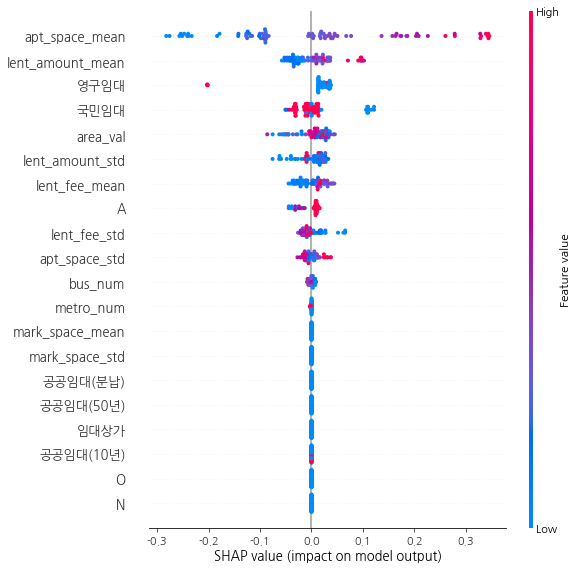

In [15]:
shap.summary_plot(shap_values, x_valid_norm)

area_val


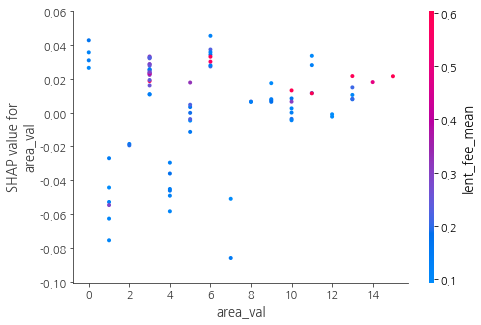

metro_num


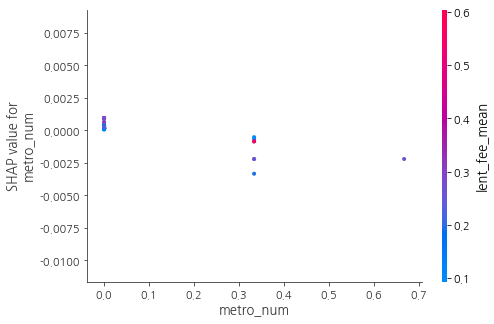

bus_num


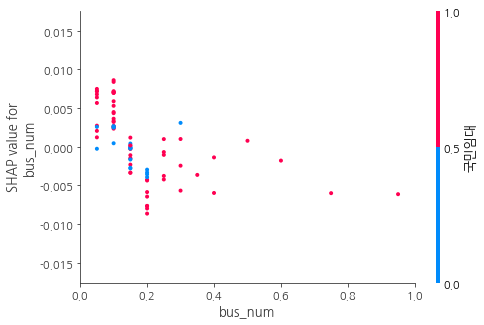

apt_space_mean


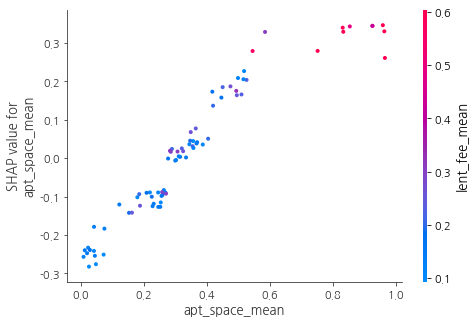

apt_space_std


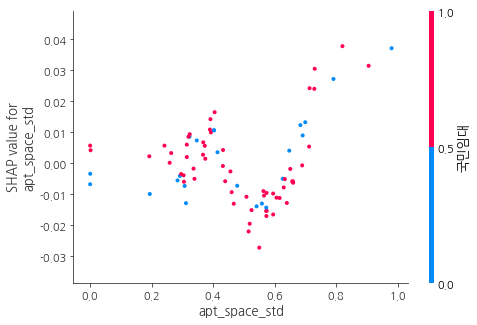

mark_space_mean


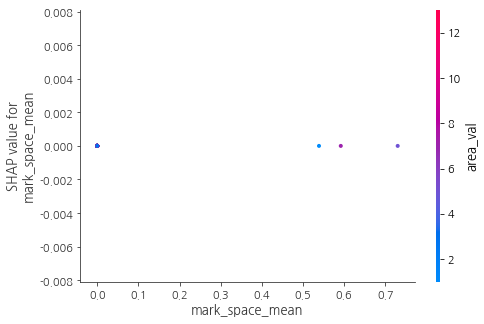

mark_space_std


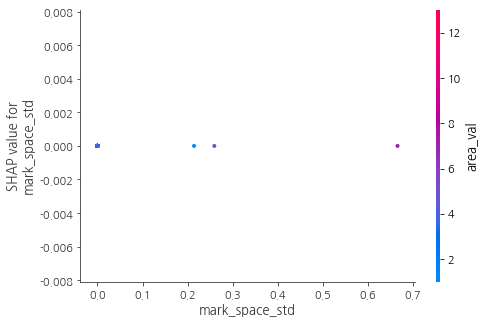

lent_amount_mean


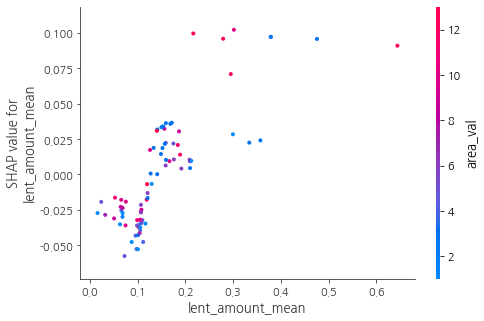

lent_amount_std


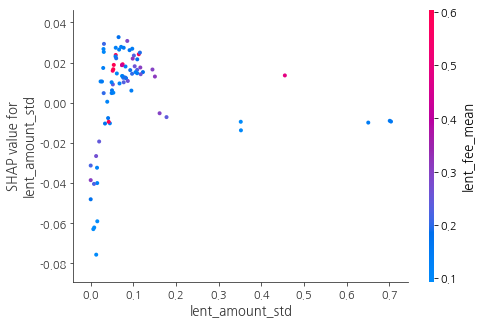

lent_fee_mean


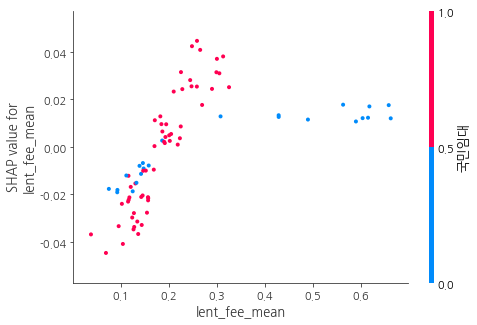

lent_fee_std


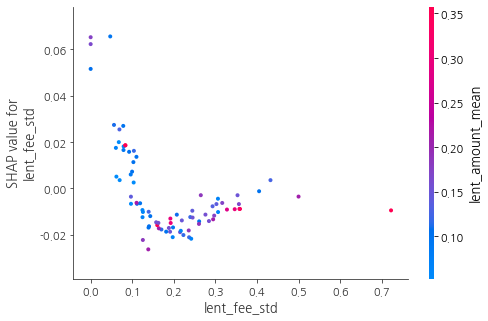

국민임대


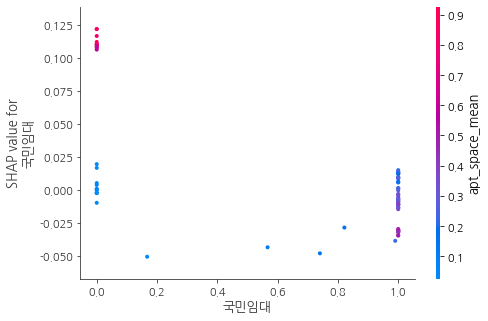

공공임대(50년)


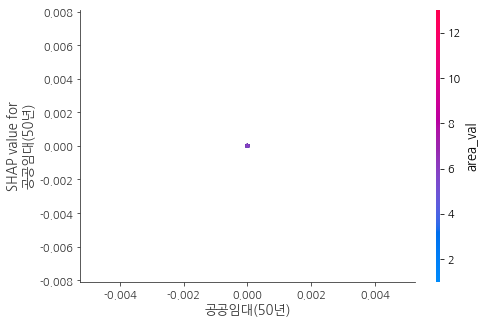

영구임대


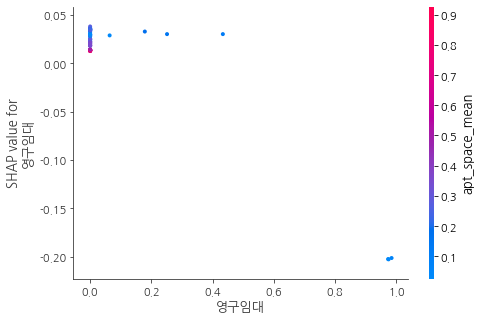

임대상가


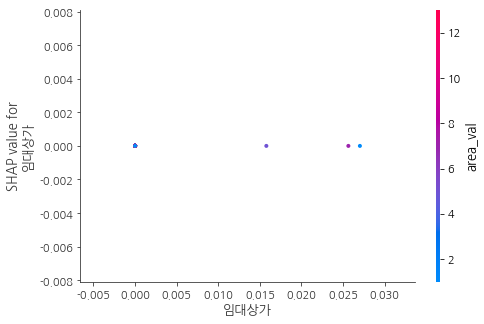

공공임대(10년)


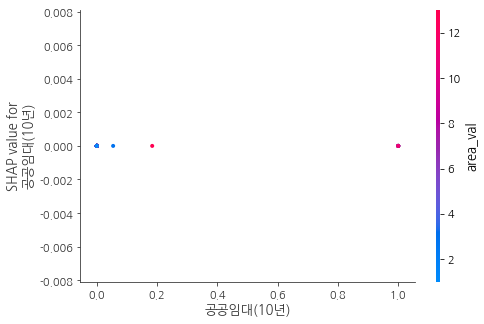

공공임대(분납)


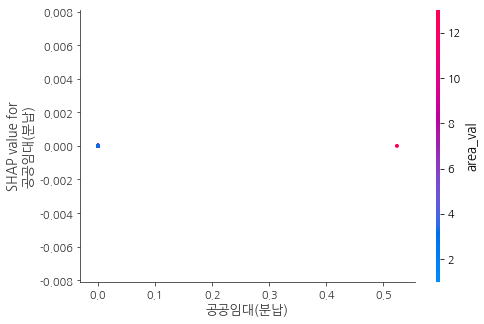

장기전세


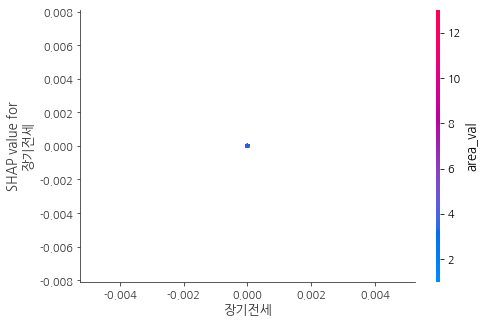

행복주택


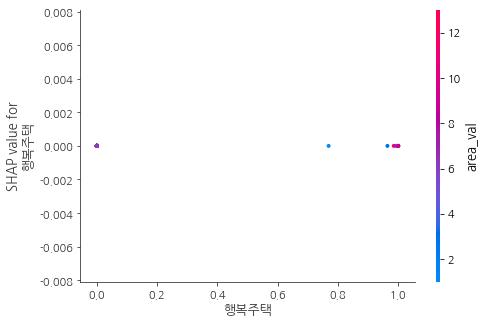

공공임대(5년)


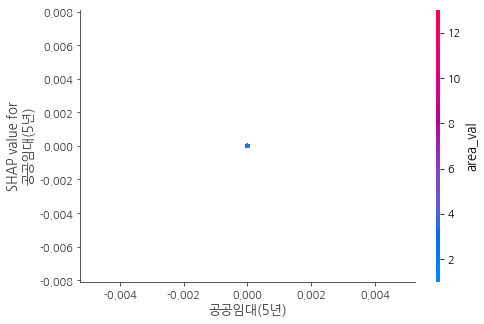

A


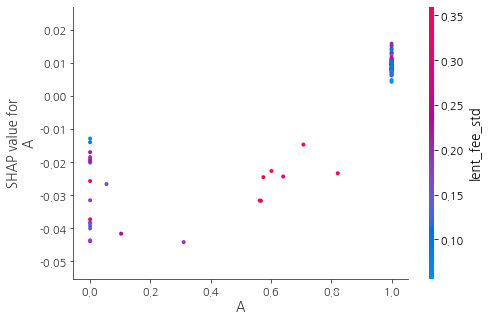

B


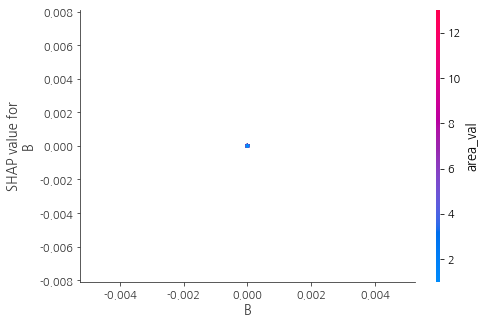

C


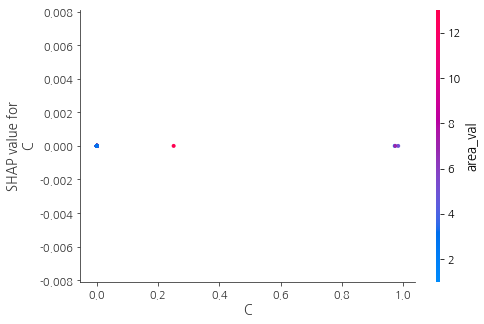

D


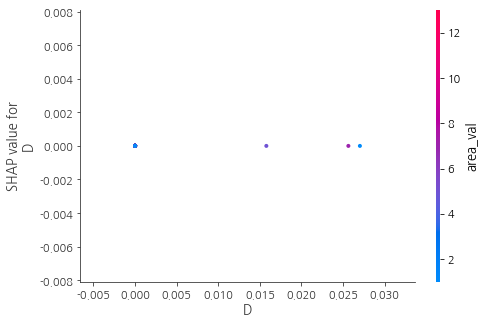

F


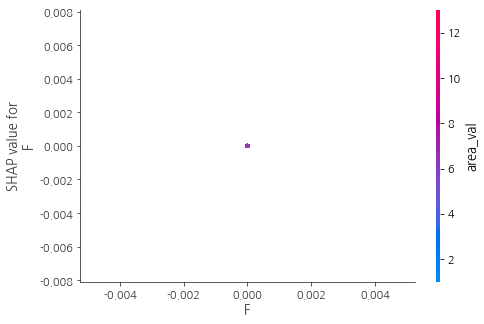

E


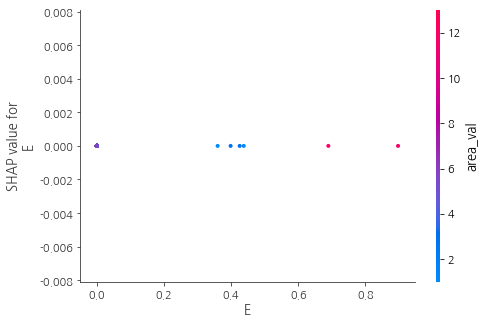

G


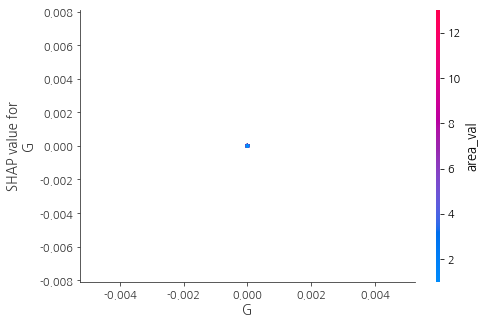

H


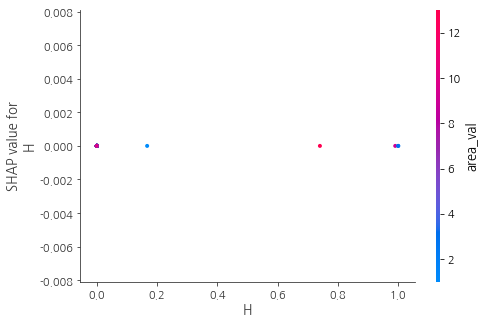

I


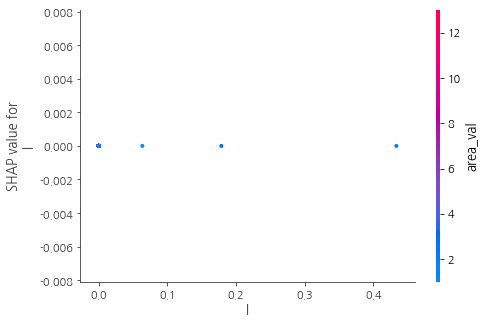

J


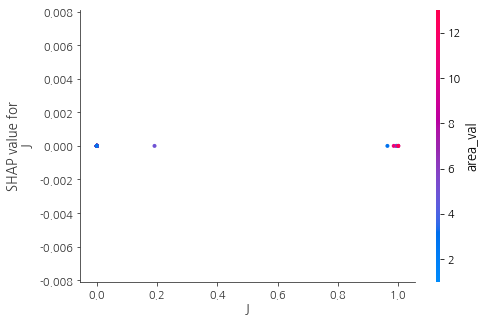

K


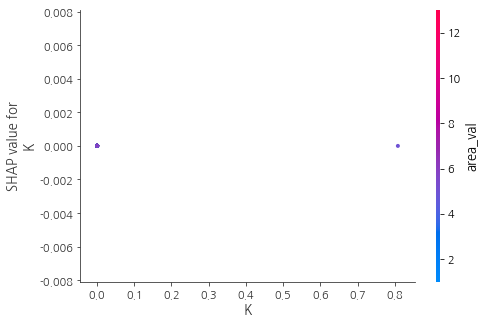

L


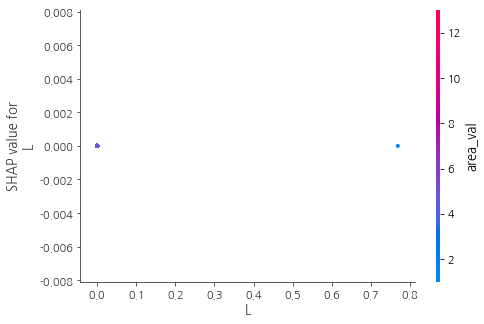

M


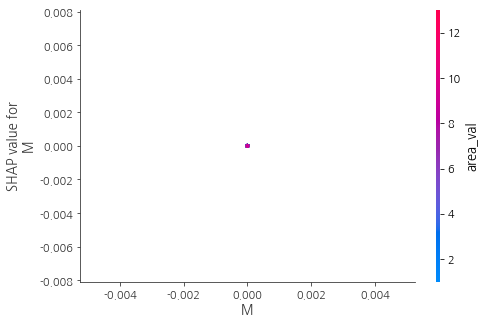

N


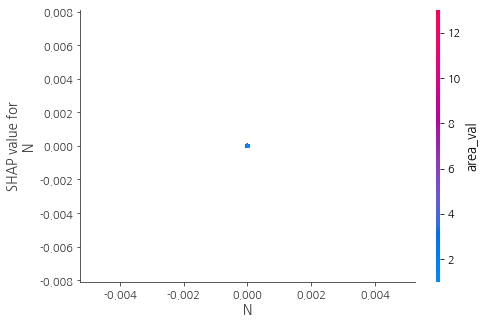

O


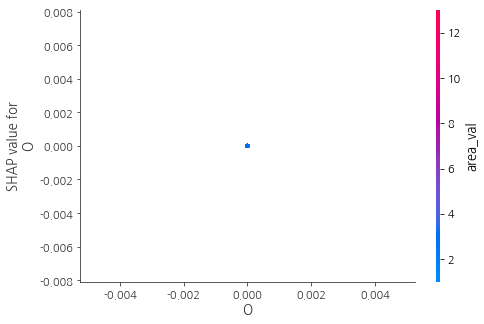

In [16]:
for col in x_valid_norm.columns:
    print(col)
    shap.dependence_plot(col, shap_values, x_valid_norm)
    plt.show()

# 2차 모델

In [17]:
def return_second_dataset(origin_df, code_idx_list, output_from_first_model, answer=True):
    
    return_arr = []
    return_target = []
    
    for idx, ap_code in enumerate(code_idx_list):
        sample_df = origin_df[origin_df["단지코드"]==ap_code]
        
        tot_house_num = sample_df["총세대수"].values[0]
        empty_house_num = sample_df["공가수"].values[0]
        
        apt_num = sum(sample_df["임대건물구분"]=="아파트")
        mark_num = sum(sample_df["임대건물구분"]=="상가")
        
        pos_park_num = sample_df["단지내주차면수"].values[0]
        
        out_ = output_from_first_model[idx]
        
        return_arr.append([\
                           # 세대당 등록대수 * (총세대수-공가구수)
                          out_*(tot_house_num - empty_house_num),\
                           # 아파트 수
                          apt_num,\
                           # 상가 수
                          mark_num,\
                           # 주차가능 면수
                          pos_park_num,\
                           # 총 세대수
                          tot_house_num
                          ])
        if answer:
            return_target.append(sample_df["등록차량수"].values[0])
    return_arr = np.array(return_arr)
    return_target = np.array(return_target)
    return pd.DataFrame(return_arr, columns=["1차결과", "아파트수", "상가수", "주차가능면수", "총세대수"]), return_target

In [18]:
train_second_input, train_second_target = return_second_dataset(origin_df=train_df, code_idx_list=train_part_ap_idx, output_from_first_model=train_preds)

valid_second_input, valid_second_target = return_second_dataset(origin_df=train_df, code_idx_list=valid_part_ap_idx, output_from_first_model=valid_preds)

In [19]:
d_train_second = lgb.Dataset(train_second_input, label=train_second_target)
d_valid_second = lgb.Dataset(valid_second_input, label=valid_second_target)
watchlist_second = [d_valid_second]

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'max_depth': -1,
    'early_stopping_rounds' : 20,
    'learning_rate': 0.01,
    'verbose': 0
    }

n_estimators = 1000


model_second = lgb.train(params, d_train_second, n_estimators, watchlist_second, verbose_eval=1)

train_second_preds = model_second.predict(train_second_input)
valid_second_preds = model_second.predict(valid_second_input)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 117486
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 115516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 113593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 111706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 109864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 108062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's l2: 106304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Found `early_stopping_rounds` in params. Will use it instead of argument


In [20]:
train_mae = sum(abs(train_second_preds - train_second_target)) / len(train_second_preds)
valid_mae = sum(abs(valid_second_preds - valid_second_target)) / len(valid_second_preds)

print("MAE of Train : {} / Valid : {}".format(train_mae, valid_mae))

MAE of Train : 83.51429462273704 / Valid : 116.55754327337718


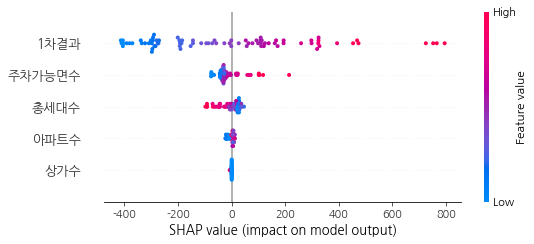

In [21]:
explainer = shap.TreeExplainer(model_second)
shap_values = explainer.shap_values(valid_second_input)

shap.summary_plot(shap_values, valid_second_input)

1차결과


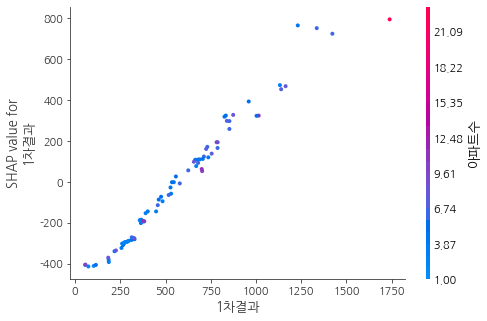

아파트수


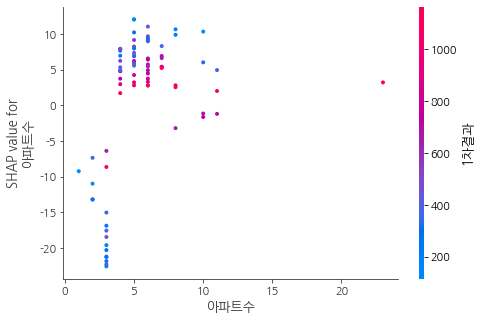

상가수


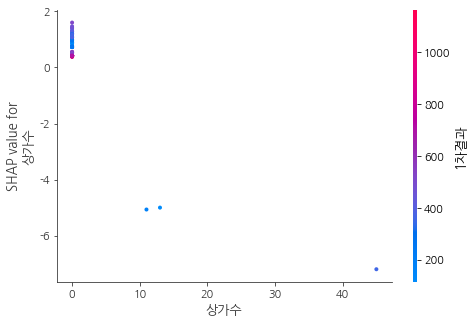

주차가능면수


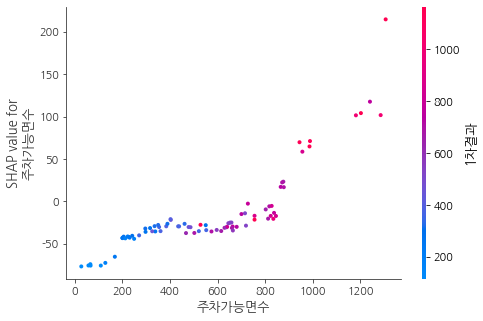

총세대수


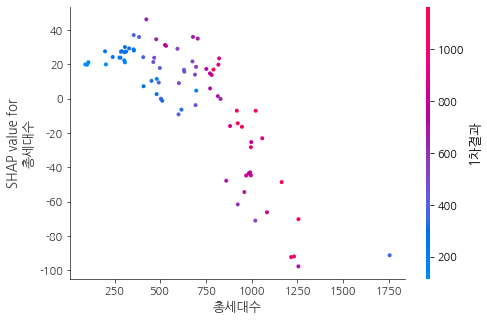

In [22]:
for col in valid_second_input.columns:
    print(col)
    shap.dependence_plot(col, shap_values, valid_second_input)
    plt.show()

# Test Set output

In [23]:
test_df = pd.read_csv("./data/test.csv")
print(test_df.shape)
test_inputs, test_targets, test_ap_idx, test_for_multiple = return_preprocessed_dataset(df=test_df, train_set=False)

test_input_norm = (test_inputs-min_for_reg) / (max_for_reg-min_for_reg)

test_preds = model_use.predict(test_input_norm)

test_second_input, valid_second_target = return_second_dataset(origin_df=test_df, code_idx_list=test_ap_idx, output_from_first_model=test_preds, answer=False)

test_second_preds = model_second.predict(test_second_input)

(1022, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area_val          150 non-null    float64
 1   metro_num         150 non-null    float64
 2   bus_num           150 non-null    float64
 3   apt_space_mean    150 non-null    float64
 4   apt_space_std     150 non-null    float64
 5   mark_space_mean   150 non-null    float64
 6   mark_space_std    150 non-null    float64
 7   lent_amount_mean  150 non-null    float64
 8   lent_amount_std   150 non-null    float64
 9   lent_fee_mean     150 non-null    float64
 10  lent_fee_std      150 non-null    float64
 11  국민임대              150 non-null    float64
 12  공공임대(50년)         150 non-null    float64
 13  영구임대              150 non-null    float64
 14  임대상가              150 non-null    float64
 15  공공임대(10년)         150 non-null    float64
 16  공공임대(분납)          150 non-null   

In [25]:
for_sub = pd.read_csv("./data/sample_submission.csv")

def transform_sub(raw):
    val = test_second_preds[test_ap_idx==raw.code]
    return val[0]

for_sub_copy = for_sub.copy()
for_sub_copy['num'] = for_sub.apply(transform_sub, axis=1)

In [26]:
for_sub_copy

,code,num
0,C1072,752.879967
1,C1128,1370.125512
2,C1456,609.352998
3,C1840,404.691493
4,C1332,1334.017670
...,...,...
145,C2456,241.425959
146,C1266,353.061650
147,C2152,102.698558
148,C1267,422.342266


In [27]:
for_sub_copy.to_csv("./Result/model_v02_01.csv", index=False)